In [11]:
import torch
import normflows as nf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader as dl
from torch.utils.data import TensorDataset as ds

In [12]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device

device(type='cuda')

In [13]:
target = nf.distributions.TwoMoons()
base = nf.distributions.DiagGaussian(2)

In [14]:
def data_loader_generator(number_of_samples,batchsize):
    data_points = target.sample(number_of_samples)
    target_data_set = ds(data_points)
    target_data_loader = dl(target_data_set,batch_size=batchsize,shuffle=True)
    return target_data_loader

In [15]:
def MAF_init():
    MAF_flows = []
    hidden = 256 #number of hidden units
    
    latent_size = 2 #input dimensions
    
    K=8

    for i in range(K):
        MAF_flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden)]
        MAF_flows += [nf.flows.Permute(2,mode="swap")]

    MAF_model = nf.NormalizingFlow(q0=base,flows=MAF_flows)

    return MAF_model

In [16]:
def train_model(model, target_data_loader):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    tolerance = 0.0001
    previous_loss = float('inf')
    early_stop = False
    losses = []
    
    for epoch in range(1000):
        if not early_stop:
            model.train()
            for data in target_data_loader:
                optimizer.zero_grad()
                
                data = data[0].to(device)  
                loss = model.forward_kld(data)
                
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                
                current_loss = loss.item()
                
                if epoch > 0:
                    loss_diff = abs(current_loss - previous_loss)
                    if loss_diff < tolerance:
                        early_stop = True
                        print(f"Early stopping at epoch {epoch+1} with loss difference {loss_diff:.6f}")
                        break
                
                losses.append(loss.item())
                
                previous_loss = current_loss
    
    plt.figure()
    plt.plot(losses)
    plt.show()

    return model

  0%|          | 0/6 [00:00<?, ?it/s]

Early stopping at epoch 316 with loss difference 0.000031


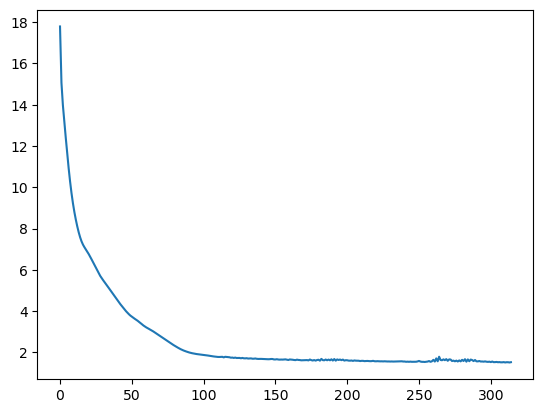

 17%|█▋        | 1/6 [00:08<00:42,  8.42s/it]

Early stopping at epoch 260 with loss difference 0.000088


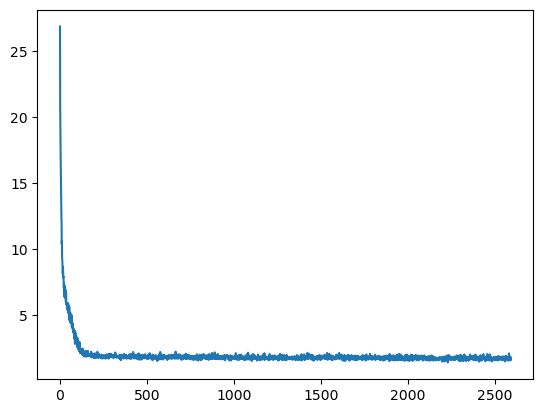

 33%|███▎      | 2/6 [01:12<02:44, 41.01s/it]

Early stopping at epoch 19 with loss difference 0.000010


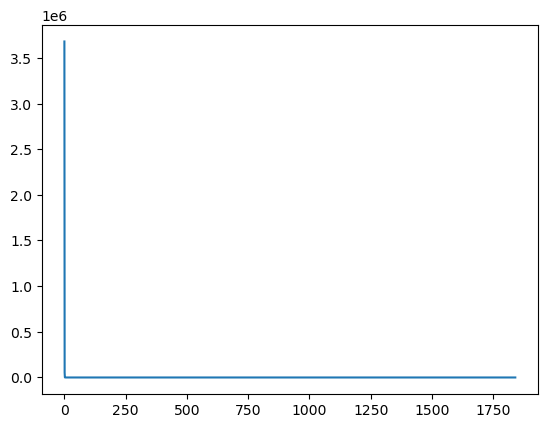

 50%|█████     | 3/6 [01:57<02:09, 43.11s/it]

Early stopping at epoch 7 with loss difference 0.000082


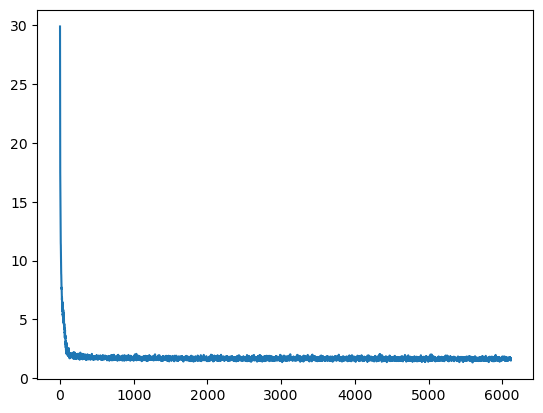

 67%|██████▋   | 4/6 [04:33<02:55, 87.50s/it]

Early stopping at epoch 2 with loss difference 0.000047


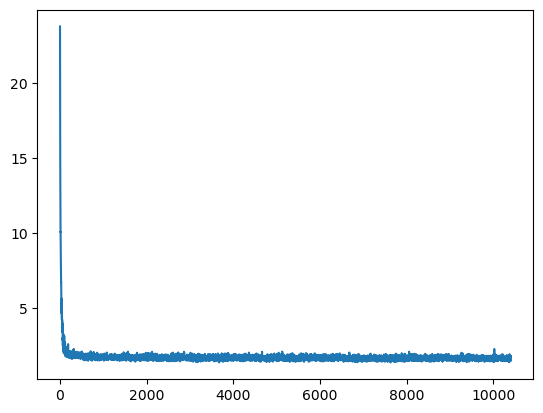

 83%|████████▎ | 5/6 [09:06<02:34, 154.30s/it]

Early stopping at epoch 2 with loss difference 0.000032


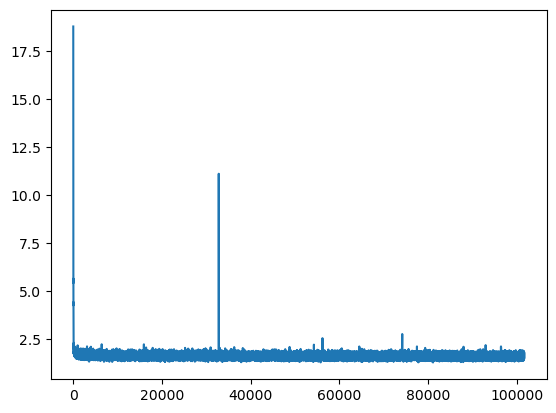

100%|██████████| 6/6 [51:17<00:00, 512.99s/it]


In [17]:
Models = []
sample_numbers = []

for numb in tqdm(range(2, 8)):
    simple_models = MAF_init().to(device=device)
    number_of_samples = 10**numb
    batch_size = 100
    Models.append(train_model(model=simple_models,target_data_loader=data_loader_generator(number_of_samples=number_of_samples,batchsize=batch_size)))
    sample_numbers.append(number_of_samples)

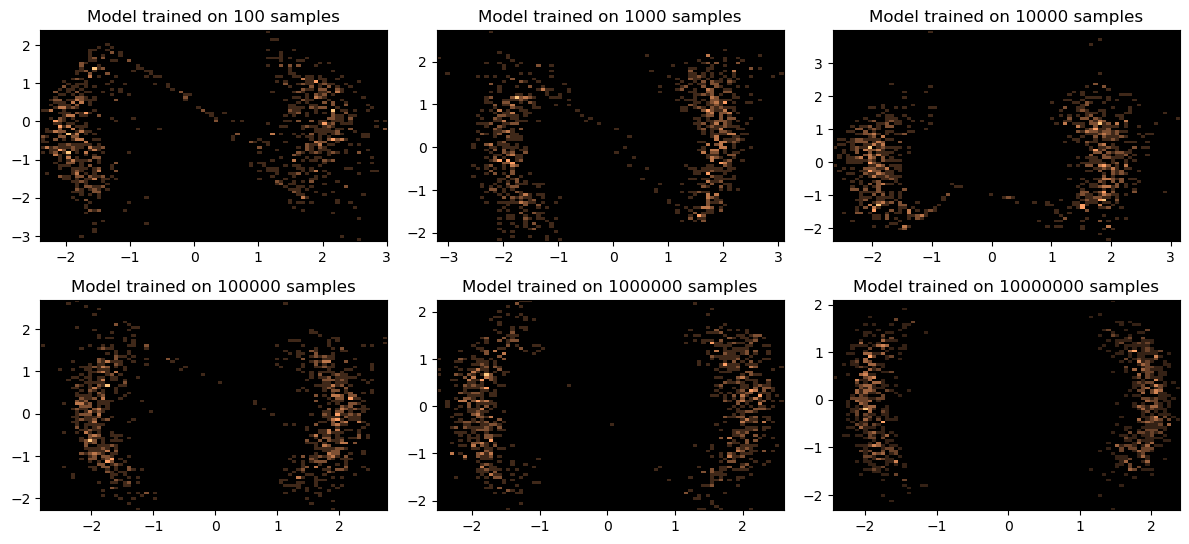

In [18]:
#checking if the models are different
plt.figure(figsize=(12,8))
with torch.no_grad():
        for i in range(len(Models)):
                k=i+1
                validation_samples = base.sample(1000).to(device)
                guesses = torch.Tensor.cpu(Models[i](validation_samples))
                plt.subplot(3,3,k)
                plt.hist2d(guesses[:,0],guesses[:,1],bins=80,cmap="copper")
                plt.title(f'Model trained on {sample_numbers[i]} samples')
                
plt.tight_layout()
plt.show()


In [19]:
KL_for_different_models=[]

x = target.sample(1000).detach().to(device)        
log_prob_target = target.log_prob(x)

with torch.no_grad():
        for i in range(len(Models)):
                        KL_for_current_sample_size = []
                        log_prob_model = Models[i].log_prob(x)
                        KL_target_model = (log_prob_target - log_prob_model).mean()

                        KL_for_different_models.append(KL_target_model.item())

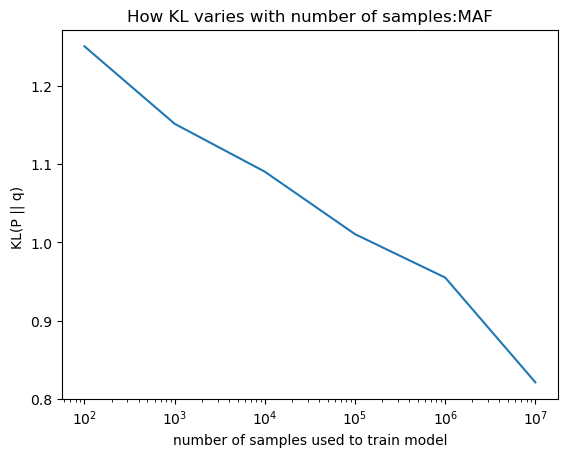

In [20]:
#plotting to see how KL Divergence values differes with number of samples
plt.plot(sample_numbers,KL_for_different_models)
plt.xlabel('number of samples used to train model')
plt.ylabel('KL(P || q) ')
plt.xscale('log')
plt.title('How KL varies with number of samples:MAF')
plt.show()